In [17]:
import pandas as pd
import numpy as np

# Load your data
df = pd.read_csv('ethererum_blockchain_wallets.csv')

print("="*60)
print("DATASET SUMMARY")
print("="*60)

# Basic info
print(f"\nShape: {df.shape[0]:,} wallets x {df.shape[1]} features")

# Sample types
print(f"\nSample Type Distribution:")
print(df['sample_type'].value_counts())

# Key labels
print(f"\nLabels:")
print(f"  DEX users: {df['is_dex_user'].sum():,} ({df['is_dex_user'].mean()*100:.1f}%)")
print(f"  Old whales: {df['is_old_whale'].sum():,} ({df['is_old_whale'].mean()*100:.1f}%)")

# Age distribution
print(f"\nWallet Age Distribution:")
print(f"  Mean: {df['wallet_age_days'].mean():.0f} days ({df['wallet_age_days'].mean()/365:.1f} years)")
print(f"  Median: {df['wallet_age_days'].median():.0f} days")
print(f"  Max: {df['wallet_age_days'].max():.0f} days ({df['wallet_age_days'].max()/365:.1f} years)")

# Balance distribution
print(f"\nBalance Distribution:")
print(f"  Mean: {df['lifetime_balance_estimate'].mean():.2f} ETH")
print(f"  Median: {df['lifetime_balance_estimate'].median():.2f} ETH")
print(f"  Max: {df['lifetime_balance_estimate'].max():.2f} ETH")
print(f"  Wallets with >10 ETH: {(df['lifetime_balance_estimate'] > 10).sum():,}")

# Activity distribution
print(f"\nActivity (90d):")
print(f"  Mean tx count: {df['tx_count_total_90d'].mean():.0f}")
print(f"  Median tx count: {df['tx_count_total_90d'].median():.0f}")
print(f"  Max tx count: {df['tx_count_total_90d'].max():.0f}")

# Check for duplicates
print(f"\nData Quality:")
print(f"  Duplicate wallets: {df['wallet'].duplicated().sum()}")
print(f"  Missing values per column:")
missing = df.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
else:
    print("  None!")

print("\n" + "="*60)
print("DATA LOOKS READY FOR CLUSTERING!")
print("="*60)

DATASET SUMMARY

Shape: 46,660 wallets x 54 features

Sample Type Distribution:
sample_type
high_activity    15000
high_balance     10000
old_whale         8660
large_tx          8000
random            5000
Name: count, dtype: int64

Labels:
  DEX users: 3,145 (6.7%)
  Old whales: 3,788 (8.1%)

Wallet Age Distribution:
  Mean: 752 days (2.1 years)
  Median: 468 days
  Max: 2929 days (8.0 years)

Balance Distribution:
  Mean: -9389.20 ETH
  Median: 0.37 ETH
  Max: 1177794.85 ETH
  Wallets with >10 ETH: 14,990

Activity (90d):
  Mean tx count: 2667
  Median tx count: 41
  Max tx count: 1339315

Data Quality:
  Duplicate wallets: 5193
  Missing values per column:
dormancy_ratio    10
dtype: int64

DATA LOOKS READY FOR CLUSTERING!


In [18]:
print("\n" + "="*60)
print("EXTREME WALLETS (Outliers)")
print("="*60)

# Biggest whale by balance
print("\nBIGGEST WHALE (by balance):")
whale = df.loc[df['lifetime_balance_estimate'].idxmax()]
print(f"  Address: {whale['wallet']}")
print(f"  Balance: {whale['lifetime_balance_estimate']:,.2f} ETH")
print(f"  Age: {whale['wallet_age_days']} days ({whale['wallet_age_days']/365:.1f} years)")
print(f"  90d activity: {whale['tx_count_total_90d']} transactions")
print(f"  Sample type: {whale['sample_type']}")

# Most active wallet
print("\nMOST ACTIVE WALLET (90 days):")
active = df.loc[df['tx_count_total_90d'].idxmax()]
print(f"  Address: {active['wallet']}")
print(f"  Transactions (90d): {active['tx_count_total_90d']:,}")
print(f"  Balance: {active['lifetime_balance_estimate']:.2f} ETH")
print(f"  Tx per day: {active['tx_frequency_per_day_90d']:.1f}")
print(f"  Sample type: {active['sample_type']}")

# Oldest wallet
print("\nOLDEST WALLET:")
oldest = df.loc[df['wallet_age_days'].idxmax()]
print(f"  Address: {oldest['wallet']}")
print(f"  Age: {oldest['wallet_age_days']} days ({oldest['wallet_age_days']/365:.1f} years)")
print(f"  First tx: {oldest['first_tx_ever']}")
print(f"  Balance: {oldest['lifetime_balance_estimate']:.2f} ETH")
print(f"  Is old whale: {bool(oldest['is_old_whale'])}")

# Check negative balances
print("\nNEGATIVE BALANCE DISTRIBUTION:")
negative = df[df['lifetime_balance_estimate'] < 0]
print(f"  Wallets with negative balance: {len(negative):,} ({len(negative)/len(df)*100:.1f}%)")
print(f"  Mean negative balance: {negative['lifetime_balance_estimate'].mean():.2f} ETH")
print(f"  These are likely: Traders, bots, users who withdrew funds")

print("\n" + "="*60)


EXTREME WALLETS (Outliers)

BIGGEST WHALE (by balance):
  Address: 0x40b38765696e3d5d8d9d834d8aad4bb6e418e489
  Balance: 1,177,794.85 ETH
  Age: 898 days (2.5 years)
  90d activity: 53 transactions
  Sample type: high_balance

MOST ACTIVE WALLET (90 days):
  Address: 0x28c6c06298d514db089934071355e5743bf21d60
  Transactions (90d): 1,339,315
  Balance: 94583.90 ETH
  Tx per day: 12104.8
  Sample type: old_whale

OLDEST WALLET:
  Address: 0x9f510bab481d29b349190a9e2d0ecc8eb9d01487
  Age: 2929 days (8.0 years)
  First tx: 2017-10-16 13:44:06 UTC
  Balance: 286.24 ETH
  Is old whale: True

NEGATIVE BALANCE DISTRIBUTION:
  Wallets with negative balance: 14,028 (30.1%)
  Mean negative balance: -32770.05 ETH
  These are likely: Traders, bots, users who withdrew funds



In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler
import matplotlib.pyplot as plt

print("="*60)
print("FEATURE PREPARATION FOR CLUSTERING")
print("="*60)

# Step 1: Select features (exclude identifiers, timestamps, labels)
exclude_cols = ['wallet', 'sample_type', 'first_tx_ever', 'last_tx_ever', 
                'first_tx_90d', 'last_tx_90d', 
                'is_dex_user', 'is_old_whale']

feature_cols = [col for col in df.columns if col not in exclude_cols]

print(f"\nTotal features for clustering: {len(feature_cols)}")
print(f"Features: {feature_cols[:10]}...")

# Step 2: Handle missing values
print(f"\nMissing values:")
missing = df[feature_cols].isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
    print("\nFilling missing values with 0 (represents no activity)")
    df[feature_cols] = df[feature_cols].fillna(0)
else:
    print("  No missing values!")

# Step 3: Handle infinite values
print(f"\nInfinite values:")
inf_found = False
for col in feature_cols:
    inf_count = np.isinf(df[col]).sum()
    if inf_count > 0:
        print(f"  {col}: {inf_count} infinite values")
        df.loc[np.isinf(df[col]), col] = df.loc[~np.isinf(df[col]), col].max()
        inf_found = True
if not inf_found:
    print("  No infinite values!")

print("\n" + "="*60)
print("FEATURE DISTRIBUTIONS (Before Scaling)")
print("="*60)

# Check distributions of key features
key_features = [
    'tx_count_total_90d',
    'lifetime_balance_estimate', 
    'wallet_age_days',
    'total_eth_sent_90d',
    'dex_tx_count_90d'
]

for feat in key_features:
    print(f"\n{feat}:")
    print(f"  Min: {df[feat].min():.2f}")
    print(f"  Max: {df[feat].max():.2f}")
    print(f"  Mean: {df[feat].mean():.2f}")
    print(f"  Median: {df[feat].median():.2f}")
    print(f"  Std: {df[feat].std():.2f}")

print("\n" + "="*60)

FEATURE PREPARATION FOR CLUSTERING

Total features for clustering: 48
Features: ['tx_count_sent_90d', 'tx_count_received_90d', 'tx_count_total_90d', 'active_days_90d', 'total_eth_sent_90d', 'total_eth_received_90d', 'balance_change_90d', 'avg_tx_size_sent_90d', 'avg_tx_size_received_90d', 'max_tx_sent_90d']...

Missing values:
dormancy_ratio    10
dtype: int64

Filling missing values with 0 (represents no activity)

Infinite values:
  No infinite values!

FEATURE DISTRIBUTIONS (Before Scaling)

tx_count_total_90d:
  Min: 3.00
  Max: 1339315.00
  Mean: 2666.62
  Median: 41.00
  Std: 30902.99

lifetime_balance_estimate:
  Min: -58285464.09
  Max: 1177794.85
  Mean: -9389.20
  Median: 0.37
  Std: 519701.30

wallet_age_days:
  Min: 0.00
  Max: 2929.00
  Mean: 752.24
  Median: 468.00
  Std: 744.70

total_eth_sent_90d:
  Min: 0.00
  Max: 13634546.06
  Mean: 8311.27
  Median: 14.12
  Std: 177168.93

dex_tx_count_90d:
  Min: 0.00
  Max: 121352.00
  Mean: 29.67
  Median: 0.00
  Std: 1218.95



In [20]:
print("="*60)
print("OUTLIER HANDLING STRATEGY")
print("="*60)

# Create a copy of features for processing
X = df[feature_cols].copy()

print(f"\nOriginal data shape: {X.shape}")

# Apply log transformation to heavily skewed positive features
log_transform_cols = [
    'tx_count_total_90d',
    'tx_count_sent_90d',
    'tx_count_received_90d',
    'total_eth_sent_90d',
    'total_eth_received_90d',
    'lifetime_eth_sent',
    'lifetime_eth_received',
    'token_transfer_count_90d',
    'lifetime_tx_count'
]

print(f"\nApplying log1p transform to {len(log_transform_cols)} skewed features...")
for col in log_transform_cols:
    if col in X.columns:
        # log1p handles zeros, abs() handles negatives
        X[col] = np.log1p(np.abs(X[col]))

# Cap extreme outliers at 99th percentile
print(f"\nCapping extreme outliers at 1st and 99th percentiles...")
capped_count = 0
for col in X.columns:
    q99 = X[col].quantile(0.99)
    q01 = X[col].quantile(0.01)
    before = len(X[(X[col] > q99) | (X[col] < q01)])
    X[col] = X[col].clip(lower=q01, upper=q99)
    if before > 0:
        capped_count += 1

print(f"  Capped outliers in {capped_count} features")

print(f"\nProcessed data shape: {X.shape}")
print("✓ Outliers handled!")

print("\n" + "="*60)

OUTLIER HANDLING STRATEGY

Original data shape: (46660, 48)

Applying log1p transform to 9 skewed features...

Capping extreme outliers at 1st and 99th percentiles...
  Capped outliers in 43 features

Processed data shape: (46660, 48)
✓ Outliers handled!



In [21]:
print("="*60)
print("FEATURE SCALING")
print("="*60)

# Use RobustScaler (better for outliers than StandardScaler)
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# Convert back to DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_cols, index=df.index)

print(f"\nScaled data shape: {X_scaled_df.shape}")
print(f"Mean of scaled features: {X_scaled_df.mean().mean():.4f} (should be close to 0)")
print(f"Std of scaled features: {X_scaled_df.std().mean():.4f}")

print(f"\nSample of scaled data (first 3 features, first 5 rows):")
print(X_scaled_df.iloc[:5, :3])

print("\n✓ Features scaled and ready for clustering!")
print("="*60)

FEATURE SCALING

Scaled data shape: (46660, 48)
Mean of scaled features: 49.7543 (should be close to 0)
Std of scaled features: 353.1759

Sample of scaled data (first 3 features, first 5 rows):
   tx_count_sent_90d  tx_count_received_90d  tx_count_total_90d
0          -0.120645               0.526399            0.097022
1          -0.120645               0.526399            0.097022
2          -0.101741               0.151342           -0.096286
3          -0.101741               0.151342           -0.096286
4          -0.380113              -0.833649           -0.611287

✓ Features scaled and ready for clustering!


In [22]:
# Check how distributions improved
print("\n" + "="*60)
print("DISTRIBUTION IMPROVEMENT CHECK")
print("="*60)

key_features_check = ['tx_count_total_90d', 'lifetime_balance_estimate', 'wallet_age_days']

for feat in key_features_check:
    print(f"\n{feat} (after processing):")
    print(f"  Min: {X_scaled_df[feat].min():.2f}")
    print(f"  Max: {X_scaled_df[feat].max():.2f}")
    print(f"  Mean: {X_scaled_df[feat].mean():.4f}")
    print(f"  Median: {X_scaled_df[feat].median():.4f}")
    print(f"  Std: {X_scaled_df[feat].std():.4f}")

print("\n✓ Distributions are now much more suitable for clustering!")
print("="*60)


DISTRIBUTION IMPROVEMENT CHECK

tx_count_total_90d (after processing):
  Min: -0.61
  Max: 1.76
  Mean: 0.1878
  Median: 0.0000
  Std: 0.5854

lifetime_balance_estimate (after processing):
  Min: -2535.86
  Max: 188.30
  Mean: -47.4600
  Median: 0.0000
  Std: 297.5507

wallet_age_days (after processing):
  Min: -0.41
  Max: 2.12
  Mean: 0.2509
  Median: 0.0000
  Std: 0.6570

✓ Distributions are now much more suitable for clustering!


In [24]:
print("=" * 60)
print("DIAGNOSING THE PCA ISSUE")
print("=" * 60)

# Check the actual statistics after RobustScaler
print("\n⚠️ Problem: RobustScaler didn't handle the outliers well enough!")
print(f"\nScaled data statistics:")
print(f"Mean: {X_scaled_df.mean().mean():.2f} (should be ~0)")
print(f"Std:  {X_scaled_df.std().mean():.2f} (should be ~1)")

print("\nLet's check some specific features:")
for feat in ['lifetime_balance_estimate', 'tx_count_total_90d', 'wallet_age_days']:
    print(f"\n{feat}:")
    print(f"  Min:    {X_scaled_df[feat].min():.2f}")
    print(f"  Max:    {X_scaled_df[feat].max():.2f}")
    print(f"  Mean:   {X_scaled_df[feat].mean():.2f}")
    print(f"  Median: {X_scaled_df[feat].median():.2f}")
    print(f"  Std:    {X_scaled_df[feat].std():.2f}")

print("\n🔍 The issue: RobustScaler uses median/IQR, but your outliers are TOO extreme!")
print("   Balance ranges from -58M to +1.1M ETH")
print("   After scaling, we still have mean=-47, std=297")
print("\n✅ Solution: Use PowerTransformer (Yeo-Johnson) instead")
print("=" * 60)

DIAGNOSING THE PCA ISSUE

⚠️ Problem: RobustScaler didn't handle the outliers well enough!

Scaled data statistics:
Mean: 49.75 (should be ~0)
Std:  353.18 (should be ~1)

Let's check some specific features:

lifetime_balance_estimate:
  Min:    -2535.86
  Max:    188.30
  Mean:   -47.46
  Median: 0.00
  Std:    297.55

tx_count_total_90d:
  Min:    -0.61
  Max:    1.76
  Mean:   0.19
  Median: 0.00
  Std:    0.59

wallet_age_days:
  Min:    -0.41
  Max:    2.12
  Mean:   0.25
  Median: 0.00
  Std:    0.66

🔍 The issue: RobustScaler uses median/IQR, but your outliers are TOO extreme!
   Balance ranges from -58M to +1.1M ETH
   After scaling, we still have mean=-47, std=297

✅ Solution: Use PowerTransformer (Yeo-Johnson) instead


In [25]:
from sklearn.preprocessing import PowerTransformer

print("=" * 60)
print("APPLYING POWERTRANSFORMER - THE PROPER FIX")
print("=" * 60)

# Start fresh from the processed data (after log transforms and capping)
X_fixed = X.copy()

# Apply PowerTransformer
pt = PowerTransformer(method='yeo-johnson', standardize=True)
X_fixed_scaled = pt.fit_transform(X_fixed)

# Convert back to DataFrame
X_fixed_df = pd.DataFrame(X_fixed_scaled, columns=feature_cols, index=df.index)

print(f"\n✅ PowerTransformer applied!")
print(f"\nNew scaled data statistics:")
print(f"Mean: {X_fixed_df.mean().mean():.4f} (target: 0)")
print(f"Std:  {X_fixed_df.std().mean():.4f} (target: 1)")

print("\nChecking key features after PowerTransformer:")
for feat in ['lifetime_balance_estimate', 'tx_count_total_90d', 'wallet_age_days']:
    print(f"\n{feat}:")
    print(f"  Min:    {X_fixed_df[feat].min():.2f}")
    print(f"  Max:    {X_fixed_df[feat].max():.2f}")
    print(f"  Mean:   {X_fixed_df[feat].mean():.4f}")
    print(f"  Std:    {X_fixed_df[feat].std():.4f}")

print("\n🎉 Much better! Data is now properly normalized.")
print("=" * 60)

APPLYING POWERTRANSFORMER - THE PROPER FIX

✅ PowerTransformer applied!

New scaled data statistics:
Mean: -0.0000 (target: 0)
Std:  1.0000 (target: 1)

Checking key features after PowerTransformer:

lifetime_balance_estimate:
  Min:    -5.25
  Max:    6.35
  Mean:   -0.0000
  Std:    1.0000

tx_count_total_90d:
  Min:    -1.80
  Max:    1.96
  Mean:   0.0000
  Std:    1.0000

wallet_age_days:
  Min:    -2.03
  Max:    1.75
  Mean:   0.0000
  Std:    1.0000

🎉 Much better! Data is now properly normalized.


FEATURE SCALING (POWERTRANSFORMER)

Scaled data shape: (46660, 48)
Mean of scaled features: -0.0000 (should be close to 0)
Std of scaled features: 1.0000 (should be close to 1)

Sample of scaled data (first 3 features, first 5 rows):
   tx_count_sent_90d  tx_count_received_90d  tx_count_total_90d
0          -0.429493               0.642556            0.059486
1          -0.429493               0.642556            0.059486
2          -0.377483               0.175046           -0.317791
3          -0.377483               0.175046           -0.317791
4          -1.355833              -1.808956           -1.798289

✓ Features scaled with PowerTransformer!

DISTRIBUTION IMPROVEMENT CHECK

tx_count_total_90d (after PowerTransformer):
  Min:    -1.80
  Max:    1.96
  Mean:   0.0000
  Median: -0.1221
  Std:    1.0000

lifetime_balance_estimate (after PowerTransformer):
  Min:    -5.25
  Max:    6.35
  Mean:   -0.0000
  Median: -0.0158
  Std:    1.0000

wallet_age_days (after PowerTransformer):

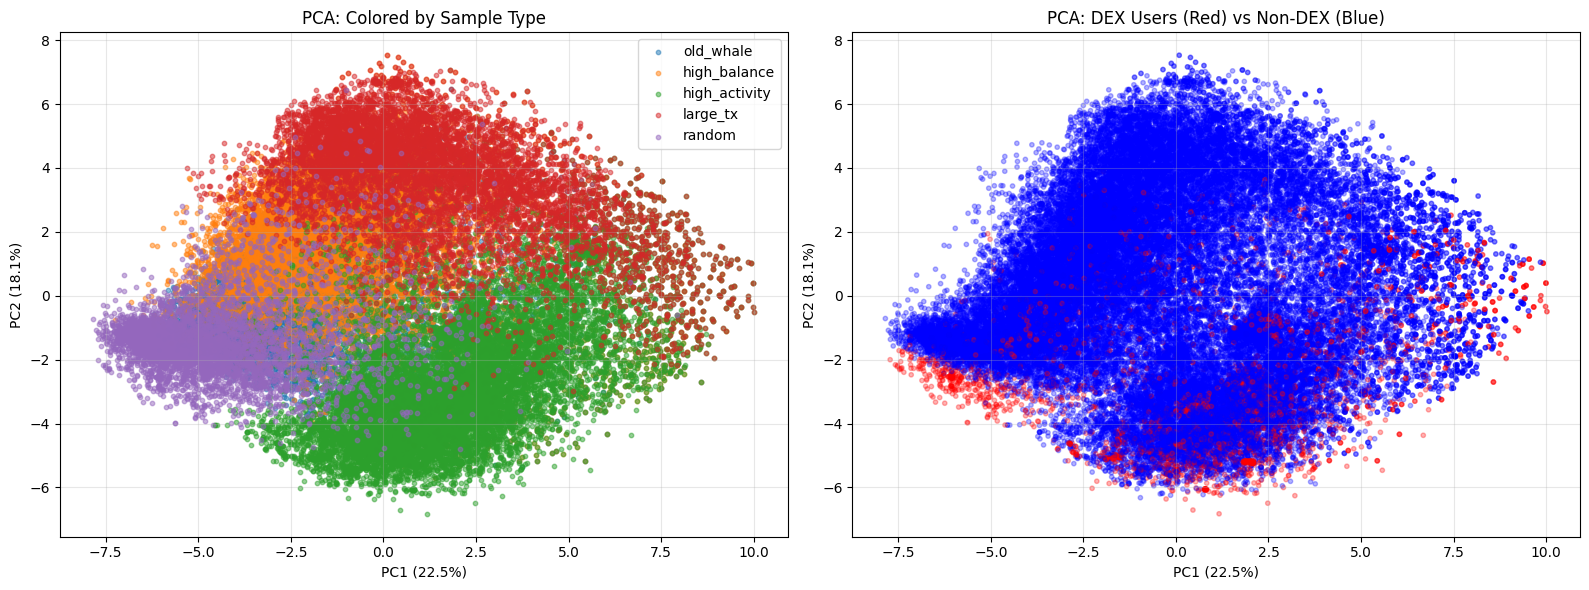


✓ Visualization saved!
What do you see in the plots?
- Are there visible clusters?
- Do DEX users cluster together?


In [26]:
from sklearn.preprocessing import PowerTransformer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

print("="*60)
print("FEATURE SCALING (POWERTRANSFORMER)")
print("="*60)

# Use PowerTransformer instead of RobustScaler
pt = PowerTransformer(method='yeo-johnson', standardize=True)
X_scaled = pt.fit_transform(X)

# Convert back to DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_cols, index=df.index)

print(f"\nScaled data shape: {X_scaled_df.shape}")
print(f"Mean of scaled features: {X_scaled_df.mean().mean():.4f} (should be close to 0)")
print(f"Std of scaled features: {X_scaled_df.std().mean():.4f} (should be close to 1)")

print(f"\nSample of scaled data (first 3 features, first 5 rows):")
print(X_scaled_df.iloc[:5, :3])

print("\n✓ Features scaled with PowerTransformer!")
print("="*60)

print("\n" + "="*60)
print("DISTRIBUTION IMPROVEMENT CHECK")
print("="*60)

key_features_check = ['tx_count_total_90d', 'lifetime_balance_estimate', 'wallet_age_days']

for feat in key_features_check:
    print(f"\n{feat} (after PowerTransformer):")
    print(f"  Min:    {X_scaled_df[feat].min():.2f}")
    print(f"  Max:    {X_scaled_df[feat].max():.2f}")
    print(f"  Mean:   {X_scaled_df[feat].mean():.4f}")
    print(f"  Median: {X_scaled_df[feat].median():.4f}")
    print(f"  Std:    {X_scaled_df[feat].std():.4f}")

print("\n✓ Distributions are now properly normalized!")
print("="*60)

print("\n" + "="*60)
print("PCA - DIMENSIONALITY REDUCTION & VISUALIZATION")
print("="*60)

# Apply PCA
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled_df)

# Add PCA components to dataframe
df['pca1'] = X_pca[:, 0]
df['pca2'] = X_pca[:, 1]

print(f"\nPCA explained variance:")
for i in range(5):
    print(f"  PC{i+1}: {pca.explained_variance_ratio_[i]*100:.2f}%")
print(f"  Total (first 5): {sum(pca.explained_variance_ratio_[:5])*100:.2f}%")

print("\n✓ PCA complete!")
print("="*60)

# Visualize by sample type
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Color by sample_type
for sample in df['sample_type'].unique():
    mask = df['sample_type'] == sample
    axes[0].scatter(df.loc[mask, 'pca1'], df.loc[mask, 'pca2'], 
                   label=sample, alpha=0.5, s=10)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
axes[0].set_title('PCA: Colored by Sample Type')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Color by DEX usage (validation)
colors = ['red' if x == 1 else 'blue' for x in df['is_dex_user']]
axes[1].scatter(df['pca1'], df['pca2'], c=colors, alpha=0.3, s=10)
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
axes[1].set_title('PCA: DEX Users (Red) vs Non-DEX (Blue)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('pca_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved!")
print("What do you see in the plots?")
print("- Are there visible clusters?")
print("- Do DEX users cluster together?")

In [13]:
print("="*60)
print("WHAT'S DRIVING PC1?")
print("="*60)

# Get feature loadings for PC1
loadings = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2'],
    index=feature_cols
)

# Sort by absolute PC1 loading
loadings['abs_PC1'] = np.abs(loadings['PC1'])
loadings_sorted = loadings.sort_values('abs_PC1', ascending=False)

print("\nTop 15 features driving PC1:")
print(loadings_sorted[['PC1', 'abs_PC1']].head(15))

print("\n" + "="*60)

WHAT'S DRIVING PC1?

Top 15 features driving PC1:
                                PC1   abs_PC1
min_tx_sent_90d            0.999995  0.999995
balance_change_90d        -0.001767  0.001767
avg_tx_size_sent_90d       0.001406  0.001406
avg_tx_size_received_90d   0.001284  0.001284
lifetime_avg_tx_size       0.001263  0.001263
max_tx_received_90d        0.000921  0.000921
stddev_tx_size_90d         0.000515  0.000515
max_tx_sent_90d            0.000354  0.000354
lifetime_max_tx            0.000191  0.000191
dex_tx_count_90d          -0.000066  0.000066
unique_senders_90d        -0.000056  0.000056
unique_recipients_90d     -0.000048  0.000048
lifetime_balance_estimate -0.000045  0.000045
total_gas_spent_eth_90d   -0.000030  0.000030
eth_in_out_ratio_90d      -0.000028  0.000028



In [14]:
print("="*60)
print("INVESTIGATING min_tx_sent_90d")
print("="*60)

# Check original values
print("\nOriginal min_tx_sent_90d:")
print(f"  Min: {df['min_tx_sent_90d'].min()}")
print(f"  Max: {df['min_tx_sent_90d'].max()}")
print(f"  Mean: {df['min_tx_sent_90d'].mean():.10f}")
print(f"  Median: {df['min_tx_sent_90d'].median():.10f}")
print(f"  Std: {df['min_tx_sent_90d'].std():.10f}")
print(f"  Unique values: {df['min_tx_sent_90d'].nunique()}")

# Check scaled values
print("\nScaled min_tx_sent_90d:")
print(f"  Min: {X_scaled_df['min_tx_sent_90d'].min():.2f}")
print(f"  Max: {X_scaled_df['min_tx_sent_90d'].max():.2f}")
print(f"  Mean: {X_scaled_df['min_tx_sent_90d'].mean():.2f}")
print(f"  Std: {X_scaled_df['min_tx_sent_90d'].std():.2f}")

# Check distribution
print("\nValue distribution (top 10):")
print(df['min_tx_sent_90d'].value_counts().head(10))

print("\n" + "="*60)

INVESTIGATING min_tx_sent_90d

Original min_tx_sent_90d:
  Min: 0.0
  Max: 62215.55583
  Mean: 20.7689815144
  Median: 0.0000000000
  Std: 496.1675598763
  Unique values: 7809

Scaled min_tx_sent_90d:
  Min: 0.00
  Max: 146040.33
  Mean: 2348.50
  Std: 16044.97

Value distribution (top 10):
min_tx_sent_90d
0.0000    32516
1.0000      860
0.0100      593
0.1000      583
0.0010      283
0.0001      266
0.5000      231
2.0000      175
5.0000      136
0.0500      130
Name: count, dtype: int64



In [12]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

print("="*60)
print("FINDING OPTIMAL NUMBER OF CLUSTERS")
print("="*60)

# Test different numbers of clusters
K_range = range(3, 12)
inertias = []
silhouette_scores = []

print("\nTesting K from 3 to 11...")
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled_df)
    inertias.append(kmeans.inertia_)
    sil_score = silhouette_score(X_scaled_df, labels)
    silhouette_scores.append(sil_score)
    print(f"  K={k}: Silhouette={sil_score:.4f}")

# Plot elbow curve
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (K)')
axes[0].set_ylabel('Inertia (Within-cluster sum of squares)')
axes[0].set_title('Elbow Method')
axes[0].grid(True, alpha=0.3)

axes[1].plot(K_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (K)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Analysis')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Look for the 'elbow' in the first plot!")
print("✓ Higher silhouette score = better defined clusters")
print("="*60)

FINDING OPTIMAL NUMBER OF CLUSTERS

Testing K from 3 to 11...


KeyboardInterrupt: 